# Explore here

## Step 1: Data acquisition

In [47]:
# Handle imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
import joblib
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from utils import plot_scatter_matrix, impute
from xgboost import XGBRegressor, XGBClassifier

### Step 1.1: Load the data

In [2]:
# Load the data from the URL
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')

### Step 1.2: Inspect the data

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Step 1.3: Prepare the data

In [5]:
# Separate features from labels
labels=data_df['Outcome']
features=data_df.drop('Outcome', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.25,
    random_state=315
)

## 2: EDA

### 2.1: Inspect data distributions

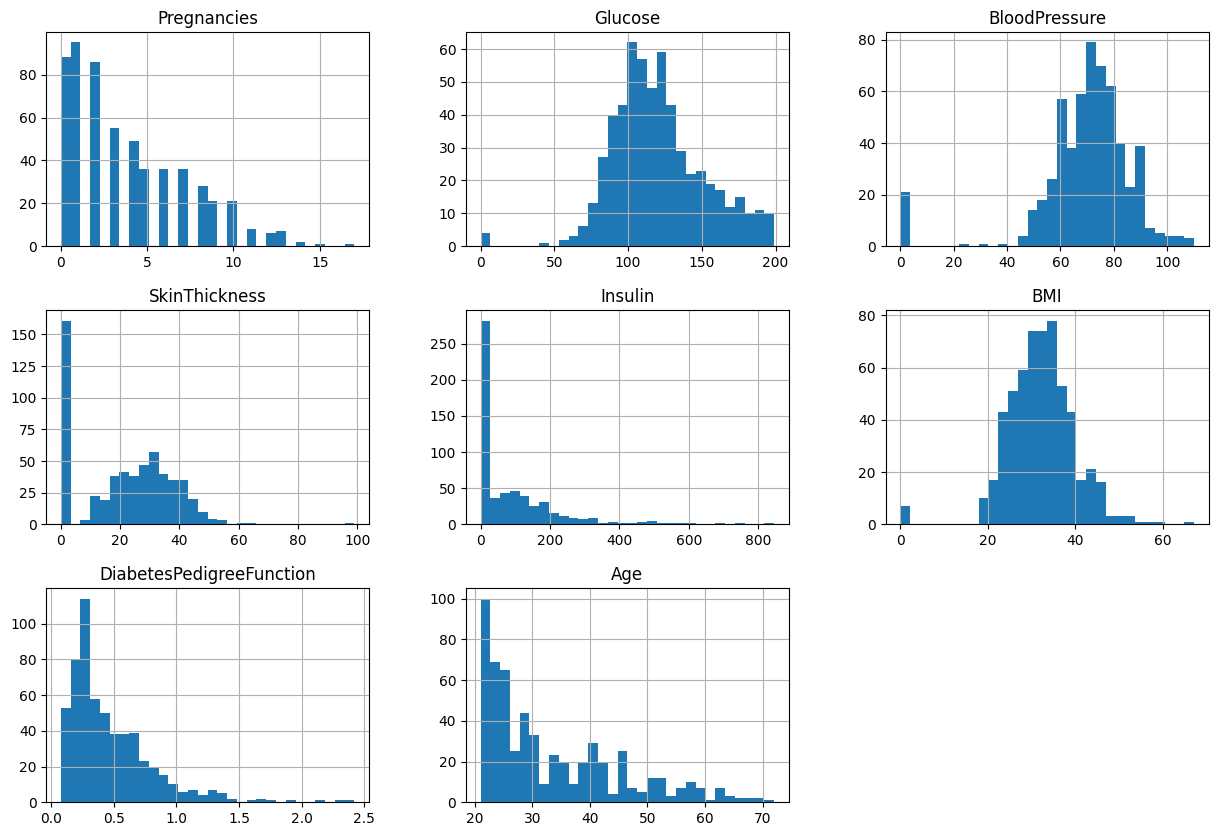

In [6]:
# Histogram for each feature
training_features.hist(bins=30, figsize=(15, 10))
plt.show()

Have 8 features for plot:
 0: Pregnancies
 1: Glucose
 2: BloodPressure
 3: SkinThickness
 4: Insulin
 5: BMI
 6: DiabetesPedigreeFunction
 7: Age


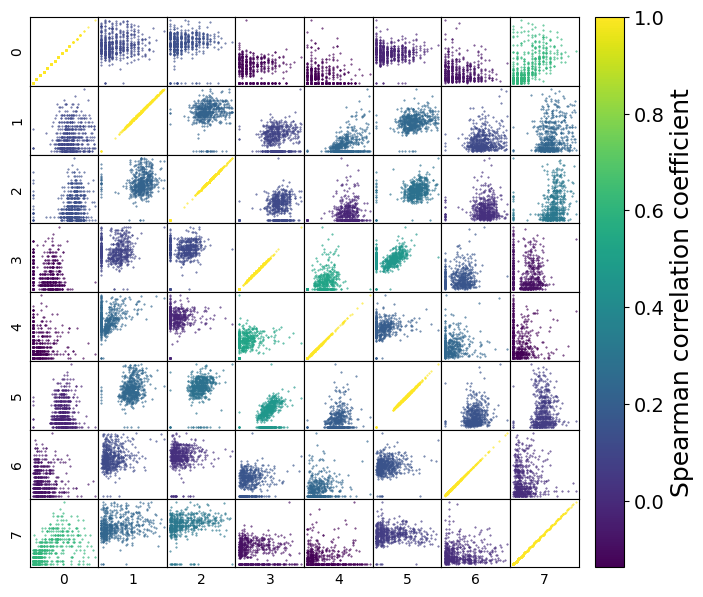

In [8]:
# Look at cross correlation matrix for training features (can try removing highly correlated features)
plot_scatter_matrix(training_features).show()

SkinThickness and BMI seem to be highly cross correlated. Insulin and BMI also seem to be highly cross correlated. SkinThickness and Insulin also have the highest number of 0 values.

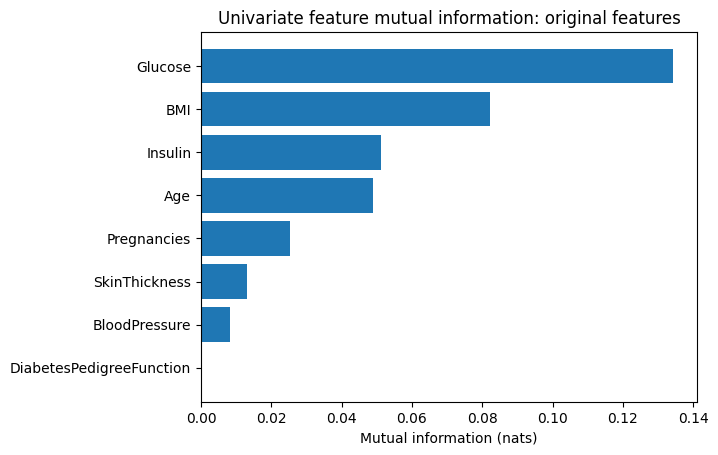

In [11]:
from sklearn.feature_selection import mutual_info_classif

results=mutual_info_classif(training_features, training_labels)

univariate_mi_results={}

for feature, result in zip(training_features.columns, results):
    univariate_mi_results[feature]=result

univariate_mi_results=dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

Glucose, BMI, and Age seem to be the most useful features. Let's try focusing on those features.

### Step 2.2: Baseline performance estimate

In [21]:
# Define a reusable helper function for cross-validation here. We are going to
# be doing a lot of cross-validation, this allows us to reuse this code
# without having to copy-paste it over and over.

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

In [ ]:
# Instantiate a gradient boosting classifier model
model=GradientBoostingClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 74.82 +/- 2.47%


### Step 2.3: Missing values

In [14]:
# Check columns for 0 values
missing_data = (data_df == 0).sum()
missing_data

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [27]:
# Use scikit-learn imputer
missing_data_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

iterative_imputed_training_features, imp, qt=impute(training_features, missing_data_features)

[IterativeImputer] Completing matrix with shape (576, 8)
[IterativeImputer] Completing matrix with shape (576, 8)


In [29]:
# Check cross validation after imputation (original accuracy: 74.82 +/- 2.47%)
scores=cross_val(model, iterative_imputed_training_features, training_labels)

Cross-validation accuracy: 73.96 +/- 3.26%


### 2.3: Feature selection

In [51]:
# Focus on the selected features based on the EDA
selected_feature_names=['Glucose','BMI','Age']
selected_training_features=iterative_imputed_training_features[selected_feature_names]

In [52]:
# Check cross validation after narrowing the features (previous best accuracy: 74.82 +/- 2.47%)
scores=cross_val(model, selected_training_features, training_labels)

Cross-validation accuracy: 73.61 +/- 2.77%


## Step 3: Build a boosting

In [54]:
# Initialize the boosting regressor
boosting_regressor=GradientBoostingRegressor(n_estimators=3, random_state=42)

# Train the model
boosting_regressor.fit(training_features, training_labels)

# Make predictions
y_pred_test=boosting_regressor.predict(testing_features)
y_pred_test

array([0.48989992, 0.26745676, 0.26745676, 0.2813911 , 0.31765821,
       0.2813911 , 0.48989992, 0.41127114, 0.48989992, 0.36214028,
       0.3607037 , 0.41127114, 0.41127114, 0.2813911 , 0.33314436,
       0.31765821, 0.29376105, 0.36214028, 0.31765821, 0.48989992,
       0.2813911 , 0.36214028, 0.26745676, 0.26745676, 0.33314436,
       0.26745676, 0.36214028, 0.26745676, 0.26745676, 0.2813911 ,
       0.26745676, 0.26745676, 0.26745676, 0.33314436, 0.2813911 ,
       0.48989992, 0.39571226, 0.41127114, 0.41127114, 0.36214028,
       0.41127114, 0.29376105, 0.26745676, 0.28264965, 0.2813911 ,
       0.33314436, 0.48989992, 0.31765821, 0.36214028, 0.48989992,
       0.29376105, 0.33314436, 0.26745676, 0.31765821, 0.41127114,
       0.31765821, 0.48989992, 0.41127114, 0.29376105, 0.31765821,
       0.36214028, 0.33314436, 0.31765821, 0.33314436, 0.2813911 ,
       0.41127114, 0.36214028, 0.2813911 , 0.41127114, 0.26745676,
       0.26745676, 0.48989992, 0.36214028, 0.41127114, 0.41127

In [55]:
# Evaluate the model
mse_test=mean_squared_error(testing_labels, y_pred_test)

print(f'Testing Mean Squared Error: {mse_test}')

Testing Mean Squared Error: 0.19663802842443975


In [58]:
xbmodel=XGBRegressor(n_estimators = 5, learning_rate = 0.1, random_state = 42)
xbmodel.fit(training_features, training_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
xb_y_pred=xbmodel.predict(testing_features)
xb_y_pred

print(f"Mean squared error: {mean_squared_error(testing_labels, xb_y_pred)}")

Mean squared error: 0.1775734011335546


## Step 4: Save the model

In [60]:
joblib.dump(boosting_regressor, 'boosting_regressor_default_42.json')
print("Model saved successfully.")

joblib.dump(xbmodel, 'xgb_regressor_default_42.json')
print("XB Model saved successfully.")

Model saved successfully.
XB Model saved successfully.


Boosting algorithm has the lowest MSE, I would use this model.

## Step 5: Analyze and compare model results

In [61]:
# Make predictions from test set features
predicted_labels=model.predict(testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 73.4% accurate on the test data
